In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
import pickle
import os.path as pth
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from time import sleep


def get_sheets_service():
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if pth.exists('sheets_token.pickle'):
        with open('sheets_token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('sheets_credentials.json', SHEETS_SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('sheets_token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    return build('sheets', 'v4', credentials=creds)

SHEETS_SERVICE = get_sheets_service()
SHEET_ID = "1MNXHNOzy8oTNa606jt2RgJ7WTXyOUwFPKotIACnwcqE"

def read_cells(cell_range):
    sheet = SHEETS_SERVICE.spreadsheets()
    result = sheet.values().get(spreadsheetId=SHEET_ID, range=cell_range)
    response = result.execute()
    sleep(1)
    return response['values']

In [7]:
print(read_cells('Query 1!E4'))

[['0.17s']]


In [9]:
DATA = []

for q in [1, 2, 3, 4, 5, 6]:
    sheet_name = f'Query {q}!D4:I13'
    data = {'time': {
                'rematch': [], 
                'ranked': []
            }, 
            'memory' : {
                'rematch': [],
                'ranked': []
            }, 
            'outputs': {
                'rematch': [],
                'ranked': []
            }
           }
    cells = read_cells(sheet_name)
    for row in cells:
        data['time']['rematch'].append(float(row[0].replace('s','')))
        data['time']['ranked'].append(float(row[1].replace('s','')))
        data['memory']['rematch'].append(row[2])
        data['memory']['ranked'].append(row[3])
        data['outputs']['rematch'].append(int(row[4].replace(',','')))
        data['outputs']['ranked'].append(int(row[5].replace(',','')))
        
    DATA.append(data)

print(DATA)

X = [200*i for i in range(1, 11)]

[{'time': {'rematch': [0.03, 0.04, 0.03, 0.02, 0.03, 0.03, 0.04, 0.04, 0.06, 0.05], 'ranked': [0.17, 0.39, 0.58, 0.65, 1.02, 1.05, 1.15, 1.32, 1.54, 1.66]}, 'memory': {'rematch': ['4.86M', '4.7M', '4.77M', '4.74M', '4.88M', '5.03M', '5.24M', '5.22M', '5.45M', '5.77M'], 'ranked': ['142.01M', '307.21M', '483.55M', '653.81M', '825.5M', '1006.26M', '1.13G', '1.28G', '1.46G', '1.61G']}, 'outputs': {'rematch': [110, 242, 387, 521, 661, 799, 908, 1012, 1158, 1268], 'ranked': [110, 242, 387, 521, 661, 799, 908, 1012, 1158, 1268]}}, {'time': {'rematch': [0.02, 0.02, 0.03, 0.03, 0.05, 0.05, 0.05, 0.06, 0.08, 0.06], 'ranked': [0.25, 0.51, 0.77, 1.04, 1.34, 1.55, 1.73, 2.01, 2.15, 2.38]}, 'memory': {'rematch': ['5.05M', '4.89M', '4.87M', '5.04M', '5.19M', '5.22M', '5.36M', '5.45M', '5.69M', '5.67M'], 'ranked': ['208.11M', '444.26M', '701.12M', '935.01M', '1.16G', '1.41G', '1.61G', '1.82G', '2.08G', '2.3G']}, 'outputs': {'rematch': [72, 157, 247, 329, 418, 507, 577, 643, 734, 804], 'ranked': [72, 1

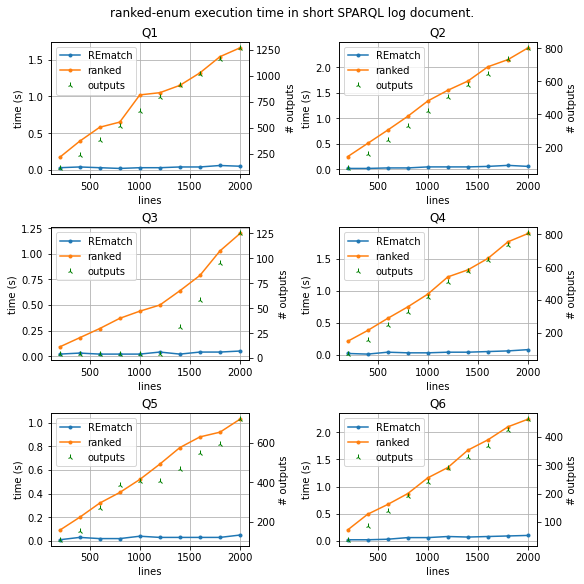

In [60]:
QUERIES = [".*sparql!x{[^\\n]*OPTIONAL[^\\n]*}\\n.*",
           ".*\\n[^\\n]*!x{sparql[^\\n]*OPTIONAL[^\\n]*OPTIONAL[^\\n]*}\\n.*",
          r".*05:[^\n]*!x{sparql[^\n]*FILTER[^\n]*}\n.*",
          r".*\n!y{[^\+]*\+}[^\n]*sparql!x{[^\n]*OPTIONAL[^\n]*OPTIONAL[^\n]*}\n.*"
          r".*json[^\n]*GROUP.BY.!y{(\?[a-z0-9]+[^a-z0-9]+)+}([A-Z][^\n]*)?\n.*",
          r".*!x{sparql[^\n]*SELECT(.DISTINCT)?[^A-Z\n]*\?e_agreedTreatment[^A-Z\n]*([A-Z][^\n]*)?}\n.*"]

fig, axs = plt.subplots(3, 2, figsize=(8,8), constrained_layout=True)

for i, (ax, query) in enumerate(zip(axs.flat, DATA)):
    
    ax.set_title(f"Q{i+1}")
    ax.grid()
    ax2 = ax.twinx()
    ax.set_ylabel('time (s)')
    ax.set_xlabel('lines')
    ax2.set_ylabel('# outputs')
    l1 = ax.plot(X, query['time']['rematch'], label='REmatch', marker='.')
    l2 = ax.plot(X, query['time']['ranked'], label='ranked', marker='.')
    l3 = ax2.plot(X, query['outputs']['rematch'], label='outputs', color='g', marker='2', linestyle='none')
    lns = l1+l2+l3
    lbs = [l.get_label() for l in lns]
    ax.legend(lns, lbs, loc=0)
    
fig.suptitle("ranked-enum execution time in short SPARQL log document.")
fig.savefig('time.png')

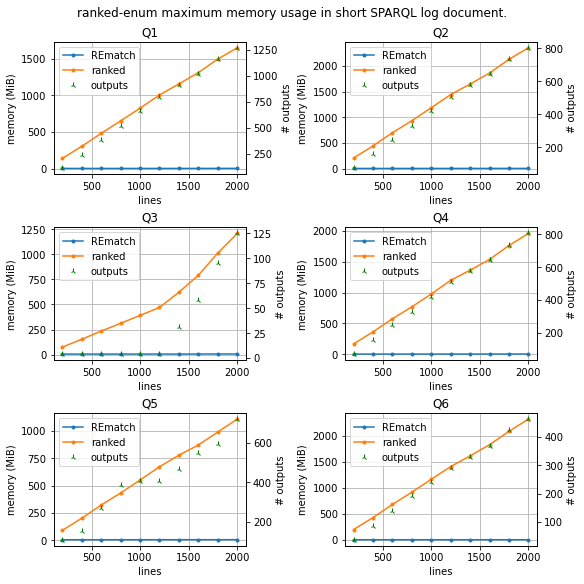

In [61]:
def convert_to_MB(s):
    if s[-1] == 'M':
        return float(s.replace('M', ''))
    elif s[-1] == 'G':
        return float(s.replace('G', '')) * 1024
    return int(s)


fig2, axs2 = plt.subplots(3, 2, figsize=(8,8), constrained_layout=True)

for i, (ax, query) in enumerate(zip(axs2.flat, DATA)):
    
    ax.set_title(f"Q{i+1}")
    ax.grid()
    ax2 = ax.twinx()
    ax.set_ylabel('memory (MiB)')
    ax.set_xlabel('lines')
    ax2.set_ylabel('# outputs')
    Y1 = list(map(convert_to_MB, query['memory']['rematch']))
    Y2 = list(map(convert_to_MB, query['memory']['ranked']))
    l1 = ax.plot(X, Y1, label='REmatch', marker='.')
    l2 = ax.plot(X, Y2, label='ranked', marker='.')
    l3 = ax2.plot(X, query['outputs']['rematch'], label='outputs', color='g', marker='2', linestyle='none')
    lns = l1+l2+l3
    lbs = [l.get_label() for l in lns]
    ax.legend(lns, lbs, loc=0)

fig2.suptitle("ranked-enum maximum memory usage in short SPARQL log document.")
fig2.savefig('memory.png')